# Project 3: Capstone Project

## Hyperdrive

### Sandeep Pawar

In [1]:
#!pip install --upgrade --upgrade-strategy eager azureml-sdk[automl,widgets,notebooks]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier

from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA

from azureml.core import Workspace, Experiment

# from azureml.widgets import RunDetails
# from azureml.train.sklearn import SKLearn
from azureml.train.hyperdrive import PrimaryMetricGoal
from azureml.train.hyperdrive import BanditPolicy
from azureml.train.hyperdrive import RandomParameterSampling, BayesianParameterSampling
from azureml.train.hyperdrive import HyperDriveConfig
from azureml.train.hyperdrive import choice
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.widgets import RunDetails
from azureml.train.automl import AutoMLConfig
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core import ScriptRunConfig
from azureml.core import Workspace, Environment
from interpret.glassbox import ExplainableBoostingClassifier

import os
from sklearn.feature_selection import SelectFromModel


seed = 123


import warnings
warnings.filterwarnings("ignore")

In [3]:
path1 = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
X = pd.read_table(path1, header=None, delim_whitespace=True)

path2 = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
y = pd.read_table(path2, header=None, usecols=[0], squeeze=True, delim_whitespace=True)

In [4]:
x1,x2,y1,y2 = train_test_split(X,y, random_state=seed, shuffle=True, stratify=y)

In [5]:
x1.head(3)

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
871,3212.46,2522.41,2200.2333,1173.8377,1.3281,100.0,101.6111,0.1211,1.4650,0.0035,...,NaN,NaN,0.4936,0.0131,0.0032,2.6457,0.0117,0.0262,0.0089,223.1018
385,3067.89,2570.93,2196.8000,1090.0084,1.3270,100.0,99.3944,0.1212,1.5001,-0.0199,...,0.0025,127.2483,0.4968,0.0096,0.0029,1.9411,0.0056,0.0071,0.0025,127.2483
611,2967.54,2573.09,2160.6000,1124.5821,1.5257,100.0,98.7122,0.1246,1.4750,0.0248,...,NaN,NaN,0.4973,0.0129,0.0030,2.6016,0.0252,0.0157,0.0046,62.3881


In [6]:
print("The training set has ", x1.shape[0], "observations and ", x1.shape[1], "features")

The training set has  1175 observations and  590 features


In [7]:

x1.dtypes.value_counts()

float64    590
dtype: int64

All 590 are numerical features. Let's find how many columns have NaN values. 

In [8]:
na_columns = []
for col in x1.columns:
    if x1.loc[:,col].isna().sum() > 0:
        na_columns.append(col)
        
print("There are", len(na_columns), "features with at least 1 NaN")        

There are 418 features with at least 1 NaN


Let's see if there are columns that have <5 unique values. 

In [9]:
unique_columns = []
for col in x1.columns:
    if x1.loc[:,col].nunique() < 3:
        unique_columns.append(col)

len(unique_columns)

122

Now, let's see if the target labels are balanced.

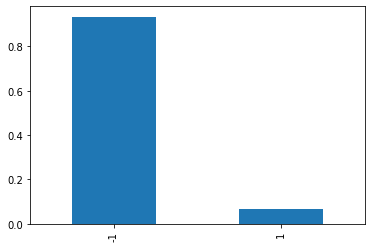

In [10]:
y1.value_counts(normalize=True).plot(kind='bar');

Labels are not balanced, 93.3% of the observations are "Pass" and remaining are "Fail". Thus, the classifier must be abale to handle 'class_weight'. 

### Observations and modeling strategy:

1. All features are numerical
2. Majority of the features have null values => Imputation will be needed
3. Features have different scales => scaling will be required
4. 122 columns have less than 3 distinct values. This means either they have near constant variance or they might be categorical.  
5. Imbalanced dataset


Keeping this in mind, we will have to build a pipeline that will include:
1. Standardization
2. Imputation
3. Variance Threshold to remove near-constant values as they will have less predictive power
4. Since number of features are very large, we will need to do dimentionality reduction. While there are many different ways, to keep things simple, I will try two approaches:
    - Feature selection by Lasso
    - By using PCA
5. Typically, use F1 or AUC as the metric since the labels are imbalanced. Also the classifier must be able to handle 'class_weight'.
6. We will try three linear algorithms (Logistic, SVC, Ridge) and two tree-based (Random Forest & lightgbm), stacking ensemble and voting ensemble. All algorithms will be based on CV to measure its 'generalizability'.
7. Finally, the final model for hyperparameter tuned to achive higher acuracy.

## Pipeline

In [11]:
fail_weight = y1.value_counts(normalize=True)[1]
pass_weight = 1-fail_weight

weights = {-1:pass_weight, 1:fail_weight}

#### Estimators

In [12]:
lr = LogisticRegression(random_state=seed)
rf = RandomForestClassifier(class_weight=weights, random_state=seed)
svc = SVC(class_weight = weights, random_state=seed)
lgbm = LGBMClassifier(objectibe='binary', random_state=seed)
ridge = RidgeClassifier(class_weight = weights, random_state=seed)
pca = PCA(n_components = 200)
lasso = LogisticRegression(penalty= 'l1', solver = 'liblinear')
gbc = GradientBoostingClassifier(random_state=seed)


stack = [('svc',svc), ('lgbm',lgbm), ('lr',lr), ('rf',rf)]

voting = VotingClassifier(stack, voting='soft')

stacking = StackingClassifier(stack, final_estimator=LogisticRegression())

In [13]:
#Define an empty dataframe to store results
result_df = pd.DataFrame()

#### Fature selection Using Lasso

Lasso is a greedy regularization approach and any features that have large weights are shrunk to zero. This can be used as a first step feature selection. I will first have to impute the values and scale them and then apply 'l1' penalty. By default, `LogisticRegression()` uses 'l2'. Note that the default solver `lbfgs` does not support `'l1` so I will use `liblinear` solver.



In [14]:
#Create copy of the training data

x_lasso = x1.copy()
x_lasso['y'] = y1

#transform the data to train a lasso model 
clean_x = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('scaler', StandardScaler()),
     ])


cc = clean_x.fit_transform(x_lasso.drop('y', axis=1))

# instatntiate SelectFromModel
sfm = SelectFromModel(lasso)

sfm.fit(cc, x_lasso.y)

#Get number of columns with non-zero coefficients
len(x_lasso.drop('y',axis=1).columns[sfm.get_support()])



208

No of features dropped from 590 to 208. We will use these features to build the model and compare the performance with model with all features. 

In [15]:
x1_lasso = x_lasso[list(x_lasso.drop('y',axis=1).columns[sfm.get_support()])]

In [16]:
x1_lasso.head(3)

,0,2,3,6,7,8,9,10,11,14,...,570,574,577,578,579,582,584,586,587,589
871,3212.46,2200.2333,1173.8377,101.6111,0.1211,1.4650,0.0035,0.0053,0.9770,10.7101,...,534.6682,3.4259,9.3398,NaN,NaN,0.4936,0.0032,0.0117,0.0262,223.1018
385,3067.89,2196.8000,1090.0084,99.3944,0.1212,1.5001,-0.0199,-0.0289,0.9382,9.8032,...,533.1600,3.2524,17.7998,0.0056,0.0071,0.4968,0.0029,0.0056,0.0071,127.2483
611,2967.54,2160.6000,1124.5821,98.7122,0.1246,1.4750,0.0248,-0.0097,0.9551,10.2465,...,531.0854,3.3856,14.1723,NaN,NaN,0.4973,0.0030,0.0252,0.0157,62.3881


In [17]:
trainx_lasso = x1_lasso.copy()
trainx_lasso['y'] = y1
trainx_lasso.to_csv('train_lasso.csv')
# x1_lasso.to_csv('trainx_lasso.csv') # Use the same columns for training and testing

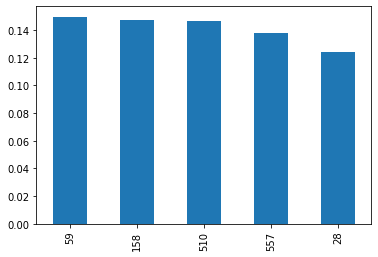

In [18]:
(x1_lasso.corrwith(y1)
     .abs()
     .sort_values(ascending = False)
     .nlargest(5)
     .plot(kind='bar'));

#### Identify number components to keep in PCA

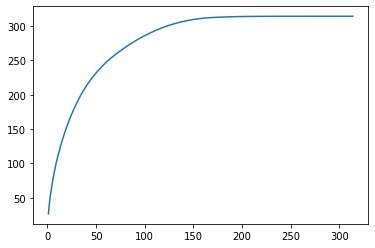

In [19]:
pca1=PCA()


clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),

])

x_x = clf2.fit_transform(x1)



pca1.fit(x_x)
v=pca1.explained_variance_
plt.plot(np.arange(1,len(v)+1), np.cumsum(v));

As can be seen from the plot above, the explained variance levels off after ~200 components. Thus, we can safely keep the first 200 components. This will reduce the number of features from 590 to 200. 

### With all features

In [20]:
name = "lr_all_feats"

clf1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('classification', lr)
])
clf1.fit(x1, y1)

score1 = cross_val_score(clf1, X=x1, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name, 'auc':score1.mean(), 'auc_std':score1.std() }, ignore_index=True)

In [21]:
result_df

,Classifier,auc,auc_std
0,lr_all_feats,0.657353,0.039802


### With features from Lasso

Note that the features were selected using Lasso (l1) while the classification model will be built using Ridge (l2)

In [22]:
name = "lr_lasso"

clf1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('classification', lr)
])
clf1.fit(x1_lasso, y1)

score1 = cross_val_score(clf1, X=x1_lasso, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name, 'auc':score1.mean(), 'auc_std':score1.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr_all_feats,0.657353,0.039802
1,lr_lasso,0.729201,0.035660


#### Logistic Regression w/ PCA 

Using the first 200 components identified from PCA

In [23]:
name = "lr_pca"

clf1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('PCA', pca),
    ('classification', lr)
])
clf1.fit(x1, y1)

score1 = cross_val_score(clf1, X=x1, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name, 'auc':score1.mean(), 'auc_std':score1.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr_all_feats,0.657353,0.039802
1,lr_lasso,0.729201,0.035660
2,lr_pca,0.659785,0.041935


Using the features identified from lasso improved the AUC significantly. PCA did not show any significant improvement. While we can further apply PCA on the lasso features to reduce the dimentionality, I will leave that as a future exercise. 

#### SVC w/ Lasso

In [24]:
name = "svc"

clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('classification', svc)
])
clf2.fit(x1_lasso, y1)

score2 = cross_val_score(clf2, X=x1_lasso, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name , 'auc':score2.mean(), 'auc_std':score2.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr_all_feats,0.657353,0.039802
1,lr_lasso,0.729201,0.035660
2,lr_pca,0.659785,0.041935
3,svc,0.718400,0.057257


#### Ridge Classifier

In [25]:
name = "ridge"

clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('classification', ridge)
])
clf2.fit(x1_lasso, y1)

score2 = cross_val_score(clf2, X=x1_lasso, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name , 'auc':score2.mean(), 'auc_std':score2.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr_all_feats,0.657353,0.039802
1,lr_lasso,0.729201,0.035660
2,lr_pca,0.659785,0.041935
3,svc,0.718400,0.057257
4,ridge,0.690443,0.040206


#### RandomForest

In [26]:
name = "rf"

clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('classification', rf)
])
clf2.fit(x1_lasso, y1)

score2 = cross_val_score(clf2, X=x1_lasso, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name , 'auc':score2.mean(), 'auc_std':score2.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr_all_feats,0.657353,0.039802
1,lr_lasso,0.729201,0.035660
2,lr_pca,0.659785,0.041935
3,svc,0.718400,0.057257
4,ridge,0.690443,0.040206
5,rf,0.653560,0.066143


#### Gradient Boosting Classifier

In [27]:
name = "GBC"

clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('classification', gbc)
])
clf2.fit(x1_lasso, y1)

score2 = cross_val_score(clf2, X=x1_lasso, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name , 'auc':score2.mean(), 'auc_std':score2.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr_all_feats,0.657353,0.039802
1,lr_lasso,0.729201,0.035660
2,lr_pca,0.659785,0.041935
3,svc,0.718400,0.057257
4,ridge,0.690443,0.040206
5,rf,0.653560,0.066143
6,GBC,0.736042,0.047221


#### VotingClassifier Ensemble

In [28]:
name = "voting"

lr = LogisticRegression(random_state=seed)
rf = RandomForestClassifier(random_state=seed)
svc = SVC(random_state=seed, probability=True)
gbc = GradientBoostingClassifier(random_state=seed)


stack = [('svc',svc), ('gbc',gbc), ('lr',lr), ('rf',rf)]

voting = VotingClassifier(stack, voting='soft')


clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('classification', voting)
])
clf2.fit(x1_lasso, y1)

score2 = cross_val_score(clf2, X=x1_lasso, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name , 'auc':score2.mean(), 'auc_std':score2.std() }, ignore_index=True)

result_df



,Classifier,auc,auc_std
0,lr_all_feats,0.657353,0.039802
1,lr_lasso,0.729201,0.035660
2,lr_pca,0.659785,0.041935
3,svc,0.718400,0.057257
4,ridge,0.690443,0.040206
5,rf,0.653560,0.066143
6,GBC,0.736042,0.047221
7,voting,0.756448,0.023428


#### Stacking Ensemble

In [29]:
name = "stacking"

stack = [('svc',svc), ('gbc',gbc), ('lr',lr), ('rf',rf)]

stacking = StackingClassifier(stack, final_estimator=LogisticRegression())


clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('classification', stacking)
])
clf2.fit(x1_lasso, y1)

score2 = cross_val_score(clf2, X=x1_lasso, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name , 'auc':score2.mean(), 'auc_std':score2.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr_all_feats,0.657353,0.039802
1,lr_lasso,0.729201,0.035660
2,lr_pca,0.659785,0.041935
3,svc,0.718400,0.057257
4,ridge,0.690443,0.040206
5,rf,0.653560,0.066143
6,GBC,0.736042,0.047221
7,voting,0.756448,0.023428
8,stacking,0.750062,0.034042


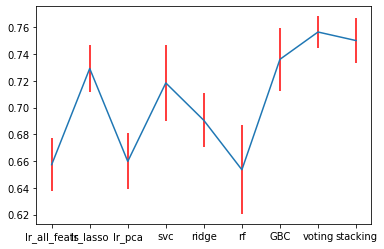

In [30]:
plt.errorbar(result_df.Classifier, result_df.auc, yerr=result_df.auc_std/2, ecolor = 'r',);

## Observations:

1. Reducing the number of features from 590 to 207, improved the AUC. Half of the features were just noise.
2. PCA did not improve the results compared to using all the features or using the non-zero lasso features
3. Voting Classifier performed significantly better on AUC than any other classifier, followed by stacking
4. The individual best classifier was Gradient Boosting Classifier
5. Voting and stacking did significantly better despite not using `class_weight` argument. Scikit-learn does not allow using class weights with voting and stacking, it's a bug.  
6. Voting classifier also has the lowest variance across the 5 folds, thus we can expect it to do well on the test set.
7. I will use Azure ML Hyperdrive to tune the voting classifier


## Hyperparameter Tuning the Voting Classifier

1. We will tune the parameters for each of the individual classifiers in the ensemble
2. Considering we have so many parameters to choose, we can either use Random Sampling or Bayesian Sampling. 
3. Bayesian sampling should work better/faster as it converges to the optimal solution
4. Downside with Baysian sampling is that it does not have early stopping policy so it may take very long to converge. 
5. Remote compute can scale easily to allow for parallel sampling

# Create train.py

In [31]:
%%writefile train.py

'''

Training script for Udacity Project 3
Sandeep Pawar
Ver 1
Date Jan 27, 2021

'''
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


from azureml.core import Workspace, Experiment


from azureml.train.hyperdrive import PrimaryMetricGoal
from azureml.train.hyperdrive import BanditPolicy
from azureml.train.hyperdrive import BayesianParameterSampling
from azureml.train.hyperdrive import HyperDriveConfig
from azureml.train.hyperdrive import choice
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.widgets import RunDetails
from azureml.train.automl import AutoMLConfig
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core import ScriptRunConfig
from azureml.core import Workspace, Environment
import argparse
from azureml.core.run import Run
import joblib

import os



seed = 123


import warnings
warnings.filterwarnings("ignore")
run = Run.get_context()



def load_data(train_df):
    
    # Load data with all the columns from the source
    # x is teh training data
    # y is the label for the training data
    
    path = 'https://raw.githubusercontent.com/sapawar4/datasets/main/datasets/SECOM/train_lasso.csv'

    
    data = pd.read_csv(path)
    
    x = data.drop(['y','Unnamed: 0'] , axis=1)
    y = data['y']
    
    
    return x, y 

dataframe = pd.read_csv('https://raw.githubusercontent.com/sapawar4/datasets/main/datasets/SECOM/train_lasso.csv')

x, y = load_data(dataframe)

def main():
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--lrc', type=float, default=1, help="LR_C")
    parser.add_argument('--rfnest', type=int, default=100, help="rf_n_estimators")
    parser.add_argument('--rfdepth', type=int, default=5, help="rf depth")
    parser.add_argument('--rfsplit', type=int, default=2, help="rf_min_sample_split")


    args = parser.parse_args()

    run.log("LR_C:", np.float(args.lrc))
    run.log("rf_n_est:", np.float(args.rfnest))
    run.log("rf_depth:", np.float(args.rfdepth))
    run.log("rf_min_sam_split:", np.float(args.rfsplit))

    
    lr = (LogisticRegression(random_state=seed, 
                             C = args.lrc ))
    rf = (RandomForestClassifier(random_state=seed, 
                                 n_estimators = args.rfnest, 
                                 max_depth = args.rfdepth,
                                 min_samples_split = args.rfsplit))
    svc = (SVC(random_state=seed, 
               probability=True))
    gbc = (GradientBoostingClassifier(random_state=seed))
  



    stack = [('svc',svc), ('gbc',gbc), ('lr',lr), ('rf',rf)]

    voting = VotingClassifier(stack, voting='soft')


    clf = Pipeline([
        ('imputer', SimpleImputer(strategy='median')), # To impute missing values
        ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
        ('scaler', StandardScaler()),
        ('classification', voting)
    ])
    clf.fit(x, y)

    score = cross_val_score(clf, X=x, y=y, cv=5, scoring = 'roc_auc')
        
    
    run.log("Mean_AUC", np.float( score.mean()))
    run.log("Std_AUC", np.float( score.std()))

    #Serialize the model
    os.makedirs('outputs', exist_ok=True)
    joblib.dump(clf, 'outputs/hyperDrive_{}_{}'.format(args.lrc,args.rfnest))

if __name__ == '__main__':
    main()

Overwriting train.py


# Create Azure ML Hyperdrive

### Define Azure Workspace & Compute

In [32]:
ws =Workspace.from_config()
exp = Experiment(workspace=ws, name="Project3")

print(ws.get_details()['id'])

compute_name = "DS2V2"



try:
    vm = ComputeTarget(ws, compute_name)
    print(f"{compute_name} exists already")
except:
    compute_config = AmlCompute.provisioning_configuration(vm_size="Standard_D2_V2", max_nodes=4)
    vm = ComputeTarget.create(ws, compute_name, compute_config)
    
vm.wait_for_completion(show_output=True)

/subscriptions/6b4af8be-9931-443e-90f6-c4c34a1f9737/resourceGroups/aml-quickstarts-136429/providers/Microsoft.MachineLearningServices/workspaces/quick-starts-ws-136429
DS2V2 exists already
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


### Define Hyperdrive Config

In [33]:
# Specify parameter sampler



param_space = { 
                                    "--lrc"        : choice(0.1,1,5,10), 
                                    "--rfnest"     : choice(100,300),
                                    "--rfdepth"    : choice(3,5,7),
                                    "--rfsplit"    : choice(2,3),
                                    
                                    
              }

sampling = BayesianParameterSampling(param_space)

# Specifying Bandit Policy. 
# ROC will be evaluated at every run, starting from 21st run. 
# If the performance in the successive runs is below 91% of the best performing run, HPO will be stopped


policy = None #BanditPolicy(evaluation_interval=1, slack_factor=0.1, delay_evaluation=20)


if "training" not in os.listdir():
    os.mkdir("./training")
import shutil
shutil.copy('train.py', './training')
    
#Create a SKLearn estimator for use with train.py
# est = SKLearn(source_directory='./training', 
#               compute_target=vm, 
#               entry_script='train.py')



env = Environment.get(workspace=ws, name="AzureML-Tutorial")

src = ScriptRunConfig(source_directory='./training',
                      script='train.py',
                      compute_target=vm,
                      environment=env)                                

# Create a HyperDriveConfig using the estimator, hyperparameter sampler, and policy.
hyperdrive_config = HyperDriveConfig(run_config=src, 
                                     policy=policy, 
                                     primary_metric_name="Mean_AUC",
                                     hyperparameter_sampling=sampling,
                                     max_total_runs=100,
                                     max_duration_minutes=15,
                                     primary_metric_goal=PrimaryMetricGoal.MAXIMIZE)

In [34]:
hpo = exp.submit(hyperdrive_config)
RunDetails(hpo).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

### Get the best Model

In [36]:
best_run = hpo.get_best_run_by_primary_metric()
# best_run_metrics = best_run.get_metrics()

# best_run_metrics


In [37]:
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
Project3,HD_b692b7a8-7d0f-4c56-adbd-229ff4cef2f7_24,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [38]:
best_run.get_metrics()

{'LR_C:': 5.0,
 'rf_n_est:': 100.0,
 'rf_depth:': 7.0,
 'rf_min_sam_split:': 3.0,
 'Mean_AUC': 0.7706407222914071,
 'Std_AUC': 0.020263854784749354}

# Best Model

Best Model is Voting Ensemble from HyperDrive with mean AUC = 77.06%, the best AutoML model is also an Ensemble with AUC = 76.3%. We will use the hyperdrive model and deploy it in AzureML.

Best HyperDrive model has following parameters: 


    {'LR_C:': 5.0,
     'rf_n_est:': 100.0,
     'rf_depth:': 7.0,
     'rf_min_sam_split:': 3.0,
     'Mean_AUC': 0.7706407222914071,
     'Std_AUC': 0.020263854784749354}

### Final model

Train the final model on the entire training dataset and deploy it in service

In [39]:
## Serialize the model


name = "Final Model"
import joblib

seed = 123
from sklearn.svm import LinearSVC

lr = LogisticRegression(random_state=seed, C = 5)
rf = RandomForestClassifier(random_state=seed, max_depth = 7,min_samples_split = 3, n_estimators = 100 )
gbc = GradientBoostingClassifier(random_state=seed, n_estimators = 100)

stack = [ ('gbc',gbc), ('lr',lr), ('rf',rf)]

voting = VotingClassifier(stack, voting='soft')

final = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('classification', voting)
])
final.fit(x1_lasso, y1)

joblib_file = "final_model.pkl"
joblib.dump(final, joblib_file)





['final_model.pkl']

### Register and Deploy Model

In [40]:
from azureml.core import Model
from azureml.core.resource_configuration import ResourceConfiguration

model = Model.register(workspace = ws, 
                      model_name = "hyperdrive",
                      model_path = './final_model.pkl',
                      model_framework=Model.Framework.SCIKITLEARN,
                      resource_configuration=ResourceConfiguration(cpu=1, memory_in_gb=0.5)
                      )

Registering model hyperdrive


In [41]:
service = Model.deploy(ws, "service", [model])
service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running............................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [42]:
service

AciWebservice(workspace=Workspace.create(name='quick-starts-ws-136429', subscription_id='6b4af8be-9931-443e-90f6-c4c34a1f9737', resource_group='aml-quickstarts-136429'), name=service, image_id=None, compute_type=None, state=ACI, scoring_uri=Healthy, tags=http://f7138b1d-46eb-4a6f-8390-16b94a303293.southcentralus.azurecontainer.io/score, properties={}, created_by={'azureml.git.repository_uri': 'https://github.com/sapawar4/nd00333-capstone', 'mlflow.source.git.repoURL': 'https://github.com/sapawar4/nd00333-capstone', 'azureml.git.branch': 'master', 'mlflow.source.git.branch': 'master', 'azureml.git.commit': 'd911fb0a5dea00e09e9cb54c138194048359484e', 'mlflow.source.git.commit': 'd911fb0a5dea00e09e9cb54c138194048359484e', 'azureml.git.dirty': 'True', 'hasInferenceSchema': 'True', 'hasHttps': 'False'})

In [44]:
service.state

'Healthy'

In [45]:
service.scoring_uri

'http://f7138b1d-46eb-4a6f-8390-16b94a303293.southcentralus.azurecontainer.io/score'

### Test the model

In [47]:
import json

#input = json.dumps({'data':x1_lasso.iloc[1,:].tolist(),'method': 'predict'})
input = json.dumps({'data':x1_lasso.iloc[1,:].tolist()})

output = service.run(input)

print(output)

{'predict_proba': [0.9702274335689066, 0.02977256643109342]}


- Webservice is working
- Final model was deployed and responded to request

In [48]:
import requests

headers = {'Content-type': 'application/json'}

input = json.dumps({'data':x1_lasso.iloc[1,:].tolist()})

# # response = requests.post(service.scoring_uri, input, headers = headers )


In [49]:
import requests

headers = {'Content-type': 'application/json'}

input = json.dumps({'data':x1_lasso.iloc[1,:].tolist()})
input

'{"data": [3067.89, 2196.8, 1090.0084, 99.3944, 0.1212, 1.5001, -0.0199, -0.0289, 0.9382, 9.8032, 403.6168, 0.9538, 191.3366, 1.3957, -5448.0, 3562.5, -3542.5, 1.285, 1.9965, 7.361000000000001, 70.2, 2.7444, 0.2273, 3.3728, 85.5361, 8.536, 50.3421, 63.9167, 49.6579, 86.7687, 36.03, 37.88, 362.3273, 9.9471, 0.9571, 646.9873, 59.3966, 4.55, 4.794, 0.9228, 4.5924, -5.3355, 364.5864, 10.0312, 123.8136, 13.3228, 25.3355, 724.4221, 1.1709, 145.2645, 124.3436, 165.8195, 0.0191, -0.0301, -0.0759, -0.1094, -0.0236, -0.0295, 7.401, 0.1254, 2.4104, 0.1559, 8007.85, 0.2599, -0.0014, -0.0001, -3.5885, -0.0381, -0.1407, 0.0005, -0.0093, 0.0603, 0.1761, NaN, NaN, 0.9551, 761.0178, 0.5959, 0.9802, 2.4859999999999998, 0.6881, -0.0473, 0.6586, 1.0, 2.3073, 998.4948, 158.3, 47.7, 3.9, 0.0031, 0.1099, 0.1146, 0.1025, 13.729000000000001, 7.1747, 0.61, NaN, NaN, 318.0, 1246.0, 0.092, 0.4484, 21.57, 8.2, 108.65700000000001, 0.0758, 0.078, 0.0916, 0.0967, 0.0744, 4.4899, NaN, 127.166, 0.095, 0.0069, 0.0037, 0

#### Using POST request to make predictions

In [50]:
response = requests.post(service.scoring_uri, input, headers = headers )

response.json()

{'predict_proba': [0.9702274335689066, 0.02977256643109342]}